In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd
from scipy.io import wavfile

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import librosa
from librosa import display

from sklearn.mixture import GMM
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
sigmaVectorOriginal =np.loadtxt('./features/sigmaOriginalTRAIN.txt' )
snrOriginal =np.loadtxt('./features/snrOriginalTRAIN.txt' )
exOriginal =np.loadtxt('./features/excessOriginalTRAIN.txt' )
mfccOriginal =np.loadtxt('./features/mfccOriginalTRAIN.txt' )

sigmaVectorSpoof =np.loadtxt('./features/sigmaSpoofTRAIN.txt' )
snrSpoof =np.loadtxt('./features/snrSpoofTRAIN.txt' )
exSpoof =np.loadtxt('./features/excessSpoofTRAIN.txt' )
mfccSpoof =np.loadtxt('./features/mfccSpoofTRAIN.txt' )

sigmaVectorOriginal_dev = np.loadtxt('./features/sigmaOriginalDEV.txt' )
snrOriginal_dev = np.loadtxt('./features/snrOriginalDEV.txt' )
exOriginal_dev = np.loadtxt('./features/excessOriginalDEV.txt' )
mfccOriginal_dev = np.loadtxt('./features/mfccOriginalDEV.txt' )

sigmaVectorSpoof_dev = np.loadtxt('./features/sigmaSpoofDEV.txt' )
snrSpoof_dev = np.loadtxt('./features/snrSpoofDEV.txt' )
exSpoof_dev = np.loadtxt('./features/excessSpoofDEV.txt' )
mfccSpoof_dev = np.loadtxt('./features/mfccSpoofDEV.txt' )

sigmaEva = np.loadtxt('./features/sigmaEva.txt')
snrEva = np.loadtxt('./features/snrEva.txt')
exEva = np.loadtxt('./features/excessEva.txt')
mfccEva = np.loadtxt('./features/mfccEva.txt')

y_test = np.loadtxt('./features/y_test.txt')

In [8]:
# FEATURE VECTOR

fetureVecTrainOriginal = np.vstack([sigmaVectorOriginal,snrOriginal, exOriginal]).T
fetureVecTrainSpoof = np.vstack([sigmaVectorSpoof, snrSpoof, exSpoof]).T

fetureVecDevOriginal = np.vstack([sigmaVectorOriginal_dev,snrOriginal_dev, exOriginal_dev]).T
fetureVecDevSpoof = np.vstack([sigmaVectorSpoof_dev, snrSpoof_dev, exSpoof_dev]).T

featureVecTest = np.vstack([sigmaEva,snrEva,exEva]).T

fvDev = np.concatenate([fetureVecDevOriginal,fetureVecDevSpoof])
y_dev = np.concatenate([np.zeros(fetureVecDevOriginal.shape[0]), np.ones(fetureVecDevSpoof.shape[0])])

In [4]:
def GMMLearn(X_train_original, X_train_spoof,X_test, y_test):
    for n_g in [5]:

        g1m =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=30)
        g1m.fit(X_train_original)

        g2m =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=30)
        g2m.fit(X_train_spoof)
        scores = g1m.score(X_test)  - g2m.score(X_test)
        prediction  = np.array( scores < 0).astype('int')

        accuracy = np.mean(prediction == y_test) * 100
        
        print (accuracy)
        
        return (scores)


In [15]:
sc = GMMLearn(fetureVecTrainOriginal, fetureVecTrainSpoof, featureVecTest, y_test)

45.8214339396


In [25]:
def plotROC(true, predicted, ttl = None):
    fpr, tpr, threshold = roc_curve(true, predicted, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ttl)
    plt.legend(loc="lower right")
    plt.show()

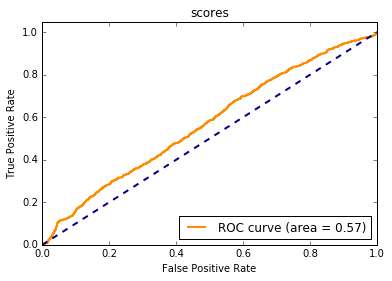

In [26]:
plotROC(y_test, sc, "scores")

In [23]:
n_g = 5
g1m =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=30)
g1m.fit(fetureVecTrainOriginal)

g2m =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=30)
g2m.fit(fetureVecTrainSpoof)

scores = g1m.score(featureVecTest)  - g2m.score(featureVecTest)
prediction  = np.array( scores < 0).astype('int')

accuracy = np.mean(prediction == y_test) * 100

print accuracy

g1_adapt = computeUBM(g1m, fetureVecDevOriginal)
g2_adapt = computeUBM(g2m, fetureVecDevSpoof)

scores = g1m.score(featureVecTest)  - g2m.score(featureVecTest)
prediction  = np.array( scores < 0).astype('int')

accuracy = np.mean(prediction == y_test) * 100
print 'accuracy - prediction on development set. adapted on 1 part train set', accuracy

47.2869382234
accuracy - prediction on development set. adapted on 1 part train set 13.7832556741


In [29]:
from collections import Counter

c = Counter(y_test)

print c

Counter({0.0: 12008, 1.0: 1298})
